# 基于NLP的用户评论情感分析与主题挖掘

## 一、项目概述

本项目爬取了京东平台 2000+ 条 iPhone 16 用户评论，通过对比传统机器学习模型（朴素贝叶斯、支持向量机、逻辑回归、随机森林）与 BERT 情感分类模型，分析评论的情感倾向。结合 LDA 和 Top2Vec 进行主题建模，挖掘用户关注的核心话题。基于可视化分析，总结产品亮点与痛点,并提出相应优化建议，为产品升级提供数据支持。

主要目标与成果：

1.  构建高精度情感分类模型，用于用户评论情感识别。

2.  应用主题建模算法，捕捉不同维度下用户关注主题。

3.  可视化分析情感分布和主题热点，生成产品优化建议。

## 二、数据获取

- **研究对象**：选择 iPhone 16 用户评论作为分析对象。作为最新款苹果手机，其用户反馈能够为后续产品优化提供参考价值。

- **数据来源**：选择京东作为数据爬取平台。相较于淘宝、天猫（评论显示受限）和拼多多（刷评比例较高），京东评论数据更完整且更具真实性。

- **爬取工具**：采用 DrissionPage 实现爬虫开发。该工具高效支持中文网站爬取，能够模拟用户操作，提高爬取成功率。

- **数据策略**：分层采集等量好评与差评，以提升数据的代表性并弱化刷评干扰。评论内容直接作为情感标签（好评/差评），为后续建模提供训练基础，并便于可视化展示。

### 1. 爬取数据

In [7]:
from DrissionPage import ChromiumOptions

# 配置浏览器路径 
path = r'C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe'     
ChromiumOptions().set_browser_path(path).save()

The configuration is saved to a file: C:\ProgramData\anaconda3\envs\bert-env\lib\site-packages\DrissionPage\_configs\configs.ini
Later the program can automatically load the configuration from the file


'C:\\ProgramData\\anaconda3\\envs\\bert-env\\lib\\site-packages\\DrissionPage\\_configs\\configs.ini'

In [7]:
from DrissionPage import Chromium
import csv
import time

tab = Chromium().latest_tab

# 商品URL
tab.get('https://item.jd.com/100118874275.html')                      
tab.scroll.to_see('.right-extra')
tab.ele('.right-extra').click()

# 监听数据
tab.listen.start('client.action')                                     

# 爬取好评
tab.ele('@text()=好评').click() 
good_comments = []
page_num = 1

while True:
    result = tab.listen.wait(timeout=3)
    tab.ele('._rateListContainer_1ygkr_45').scroll.to_bottom()
    time.sleep(1)
    body = result.response.body
    
    if 'result' not in body:
        print(f'第{page_num}页无数据,自动停止爬取,共爬取到{len(good_comments)}条好评。')
        break
        
    comments = result.response.body['result']['floors'][2]['data']  
    for item in comments:
        comment = item.get('commentInfo', {}).get('commentData')
        if comment:
            good_comments.append({'评论': comment, '标签': 1})
    page_num += 1

第103页无数据,自动停止爬取,共爬取到1021条好评。


In [5]:
from DrissionPage import Chromium
import csv
import time

tab = Chromium().latest_tab

# 商品URL
tab.get('https://item.jd.com/100118874275.html')  
tab.scroll.to_see('.right-extra')
tab.ele('.right-extra').click()

# 监听数据
tab.listen.start('client.action')  

# 爬取差评
tab.ele('@text()=差评').click()  
bad_comments = []
page_num = 1

while True:
    result = tab.listen.wait(timeout=3)
    tab.ele('._rateListContainer_1ygkr_45').scroll.to_bottom()
    time.sleep(1)
    body = result.response.body
    
    if 'result' not in body:
        print(f'第{page_num}页无数据,自动停止爬取,共爬取到{len(bad_comments)}条差评。')
        break
        
    comments = result.response.body['result']['floors'][2]['data']    
    for item in comments:
        comment = item.get('commentInfo', {}).get('commentData')
        if comment:
            bad_comments.append({'评论': comment, '标签': 0})
    page_num += 1

第102页无数据,自动停止爬取,共爬取到1009条差评。


In [8]:
# 保存数据
with open('data.csv', mode='w', newline='', encoding='utf-8') as f:   
    writer = csv.DictWriter(f, fieldnames=['评论', '标签'])
    writer.writeheader()
    writer.writerows(good_comments + bad_comments)

### 2. 数据理解

本项目共采集京东 iPhone 16 用户评论 2030 条，包含评论文本与情感标签两列。情感标签由评论星级自动生成（好评=1，差评=0），两类样本数量均衡（好评 1021 条，差评 1009 条），为模型训练提供良好基础。

In [9]:
import pandas as pd

df = pd.read_csv('data.csv', encoding='utf-8')

print('查看前几行:')
print(df.head())

print('\n查看数据行列情况:')
print(df.shape)         

print('\n查看每列的数据类型:')
print(df.info())

print('\n查看标签分布:')
print(df['标签'].value_counts())

查看前几行:
                                                  评论  标签
0  这款手机真的超棒！外观设计时尚精致，手感舒适，屏幕显示清晰细腻，色彩还原度高，操作流畅，性能...   1
1  用了国补到手5299，比实体店便宜，实体店贵的要死不敢买实体店的，正好在京东买了还是官方渠道...   1
2  几台苹果手机都是在京东买的，安全下车，苹果16非常好看，粉色粉粉嫩嫩的，它后面是磨砂那种手感...   1
3  以旧换新：这次赶上国补加上以旧换新，感觉很值得了，昨天从14看到15，最后选择了16，价格决...   1
4  外形外观：外观简洁好看\n拍照效果：很清晰，很高清，拍照的其他功能有待研究\n手感很好，比较...   1

查看数据行列情况:
(2030, 2)

查看每列的数据类型:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   评论      2030 non-null   object
 1   标签      2030 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.8+ KB
None

查看标签分布:
标签
1    1021
0    1009
Name: count, dtype: int64


## 三、数据预处理

### 1. 去重

针对爬取的评论数据，删除完全重复的评论，仅保留首次出现的记录，以避免模型训练中因重复样本导致的偏差和过拟合风险

In [10]:
import pandas as pd

df = pd.read_csv('data.csv', encoding='utf-8')

# 保留第一次出现的评论
df = df.drop_duplicates(subset='评论', keep='first')            

# 保存新数据
df.to_csv('cleaned_data.csv',index=False,encoding='utf-8')     

print("去重后数据总量：", len(df),'\n')                                
print(df['标签'].value_counts())

去重后数据总量： 1978 

标签
1    999
0    979
Name: count, dtype: int64


### 2. 数据清洗

- 去除空格、换行符、制表符等无效空白字符。

- 去除中英文标点符号。

- 去除噪音词。

In [79]:
import pandas as pd
import re

df = pd.read_csv('cleaned_data.csv')

# 定义清洗函数
def clean_text(text):

    # 去除空格、换行符、制表符
    text = re.sub(r'\s+', '', text)
    
    # 去除中英文标点
    text = text.lower()
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', '', text)
    
    # 去除噪音词
    noise_words = ['此用户未填写评价内容','默认好评', '先给好评', '系统自动好评', '评价返现', '还没用', 
                    '先评价', '评价有礼','晒单返现', '追评', '好评返现', '收到货了']
    for word in noise_words:
        text = text.replace(word, '')
    return text 

# 应用函数
df['评论'] = df['评论'].apply(clean_text)
df = df[df['评论'] != '']

# 保存结果
df.to_csv('cleaned_text_data.csv', index= False, encoding='utf-8')

print('清洗后数据量：', len(df), '\n')                                
print(df.head())

清洗后数据量： 1977 

                                                  评论  标签
0  这款手机真的超棒外观设计时尚精致手感舒适屏幕显示清晰细腻色彩还原度高操作流畅性能完全满足日常...   1
1  用了国补到手5299比实体店便宜实体店贵的要死不敢买实体店的正好在京东买了还是官方渠道还是2...   1
2  几台苹果手机都是在京东买的安全下车苹果16非常好看粉色粉粉嫩嫩的它后面是磨砂那种手感真的特别...   1
3  以旧换新这次赶上国补加上以旧换新感觉很值得了昨天从14看到15最后选择了16价格决定购买到货...   1
4  外形外观外观简洁好看拍照效果很清晰很高清拍照的其他功能有待研究手感很好比较轻盈拿着不重手单手...   1


### 3. 分词并去除停用词

- 利用 jieba 对评论文本进行中文分词。

- 去除停用词（包含常见停用词及模型训练后迭代补充的噪音词），以提升数据质量与模型效果。

- 将有效分词重新拼接为字符串，便于后续模型训练与可视化。

In [140]:
import pandas as pd
import jieba

# 加载停用词表
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

# 补充停用词
custom_stopwords = ['iphone','iphone16','苹果','手机', '京东','apple','强烈推荐','问题','真的','感觉',
                    '不错','推荐','16','喜欢','购买','惊艳','购物','一个','不好','不行','手里','太棒了',
                   '入手','满意','好评','收到','很棒','合适','特别','超级','这次','出色','不到','终于',
                   '发现','知道','出现','完全','一直','超高','半个','东西','之前','无论是','没得说','更是',
                    '现在','觉得','拿到','不用','真心','评价','一款','确实','需要','相当','有点','一下','目前',
                   '正常','这款','朋友','以后','建议','超棒','十分','人们','放心','宝贝','之后','买手机','杠杆',
                   '来说','希望','给力','直接','今天','方面','主要','用户','一点','看到']  
stopwords.update(custom_stopwords)

# 分词并连接
df = pd.read_csv('cleaned_text_data.csv')
df['text'] = df['评论'].apply(lambda x: " ".join([w for w in jieba.lcut(x) if w not in stopwords and len(w)>1]))
df = df[df['text'] != '']  
df.to_csv('token_data.csv', index= False, encoding='utf-8')
all_text = " ".join(df['text'].tolist())

print('分词后数据量：', len(df), '\n') 
print(all_text[:1000])  

分词后数据量： 1974 

外观设计 时尚 精致 手感 舒适 屏幕显示 清晰 细腻 色彩 还原 度高 操作 流畅 性能 满足 日常 使用 游戏 需求 拍照 效果 拍出 照片 质感 十足 续航 充电 速度 美中不足 盒子 到手 商家 包装 发货 环节 仔细 整体 值得 国补 到手 5299 实体店 便宜 实体店 要死 不敢 实体店 正好 官方 渠道 256g 感谢 爸爸 送来 六一 礼物 18 拥有 想要 已经 开心 好久 快递 负责 任让 拆机 态度 昨天下午 几次 物流 快递 客服 回家 起码 用个 好几年 11 换到 功能 摸索 明白 后面 日子 度过 几台 安全 下车 好看 粉色 粉粉 嫩嫩的 后面 磨砂 那种 手感 少女 拍照 清晰 特意 512g 电池 比较 抗用 13 一会 没电 毛病 发热 打游戏 很爽 手小 很大 大屏幕 不住 以旧换新 赶上 国补 以旧换新 值得 昨天 14 15 选择 价格 决定 到货 很快 回收 送货 已经 唯一 充电 算计 外形 外观 外观 简洁 好看 拍照 效果 清晰 高清 拍照 功能 有待 研究 手感 比较 轻盈 重手 单手 操作 xr 两个 对比 重手 第一天 习惯 系统 新手机 再用 8p 已经 替换 618 降价 便宜 5200 价格 比较 接受 256g 质量 外观 刮伤 损伤 降价 孩子 高考 要求 本来 pro 可惜 国补 考虑 买三多花 一千五 没多大 意义 性价比 好好 多人 128 pro 实在 不够 每天 清理 内存 太累 三星 顶级 运气 开心 一次 体验 开心 一年一度 618 大促 价格 直降 500 国家补贴 500 平台 plus200 优惠券 到手 4274 有史以来 绝无仅有 品牌 代表 品质 值得 拥有 国补 4299 便宜 原来 明显 提升 流畅 序列号 全新 官方 几年 下手 一台 老公 一段时间 颜色 大小 尺寸 款式 老公 爱惜 第一次 体验 以旧换新 价格 外形 外观 镜头 模组 排列 好看 紧凑 有型 屏幕 音效 屏幕 一流 音效 强项 拍照 效果 拍照 第一 梯队 运行 速度 流畅 日常 使用性能 过剩 国补 正品 丝滑 11 好用 速度 提升 实测 玩游戏 网络 信号 不太好 主力 期待 用个 左右 后续 回来 评论 政府 补贴 羊毛 赞省 500 一个亿 体验 流畅 

### 4. 词云图

- 基于分词结果统计词频，去除无效高频词（如品牌名、通用词），提升可视化效果。

- 为产品优化、用户需求挖掘提供直观参考。

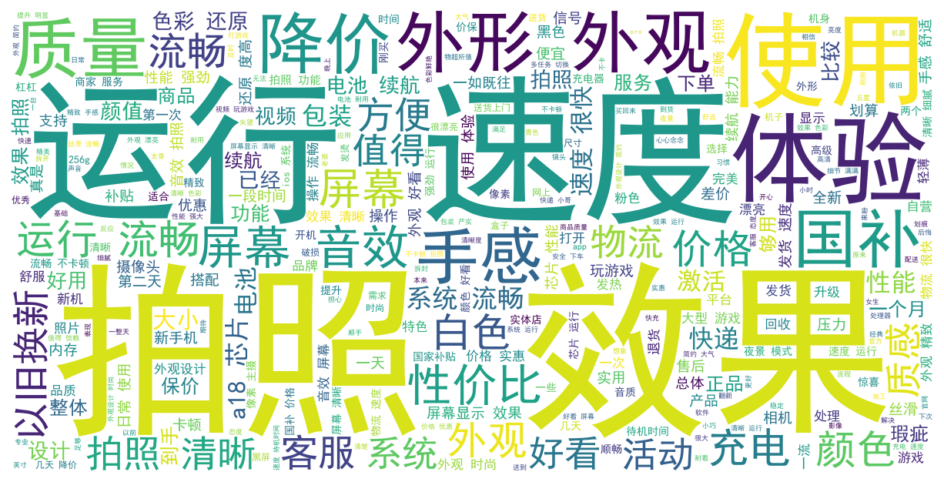

In [141]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 设置词云参数
wc = WordCloud(
    font_path='C:\\Windows\\Fonts\\simhei.ttf',  
    background_color='white',
    width=1200,
    height=600,
    max_words=300
)

wc.generate(all_text)

# 显示词云图
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 三、情感分类模型

### 1. 传统模型

为了让模型具备泛化能力并适用于未来评论数据，我在项目中首先训练了多种传统情感分类模型作为基线。考虑到数据规模为 2000 条左右，深度学习模型可能过拟合，而传统模型在小数据集上表现更稳定，因此我选择以下策略：

**文本表示**：使用 TF-IDF 作为文本向量化方案，因为它在小样本场景下对高频无用词抑制效果好，并能较好兼容传统机器学习模型。

**分类模型**：为了全面对比传统方法在情感分类任务上的表现，我训练并评估了以下常用模型：

- 朴素贝叶斯（Naive Bayes）

- 逻辑回归（Logistic Regression）

- 支持向量机（SVM）

- 随机森林（Random Forest）

**结果对比**：分别记录各模型在验证集上的准确率、精度、召回率和F1分数指标，并绘制成热力图进行对比, 为后续深度模型BERT提供基线参考。


NaiveBayes
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       194
           1       0.88      0.99      0.93       201

    accuracy                           0.92       395
   macro avg       0.93      0.92      0.92       395
weighted avg       0.93      0.92      0.92       395


LogisticRegression
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       194
           1       0.97      0.93      0.95       201

    accuracy                           0.95       395
   macro avg       0.95      0.95      0.95       395
weighted avg       0.95      0.95      0.95       395


SVM
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       194
           1       0.96      0.96      0.96       201

    accuracy                           0.96       395
   macro avg       0.96      0.96      0.96       395
weighted avg       0.96      0.96    

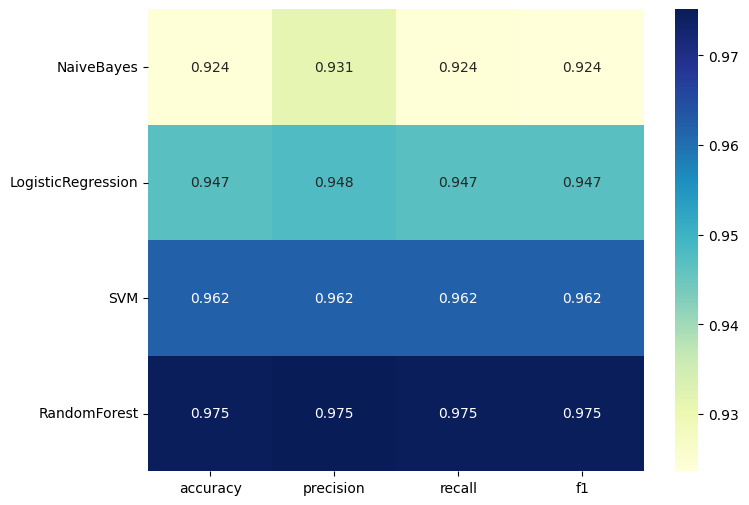

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 导入模型
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# 加载数据
df = pd.read_csv('token_data.csv')
X = df['text']     
y = df['标签']   

# TF-IDF 向量化
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 定义模型
models = {
    "NaiveBayes": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000,random_state=42),
    "SVM": LinearSVC(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# 训练与评估模型
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "accuracy": acc,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1": report['weighted avg']['f1-score']
    }
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

# 转换成 DataFrame
df_results = pd.DataFrame(results).T
df_results = df_results[['accuracy', 'precision', 'recall', 'f1']]

# 绘制热力图
plt.figure(figsize=(8,6))
sns.heatmap(df_results, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)  
plt.show()

- Naive Bayes的整体准确率为 92%。该模型对好评的召回率表现较好（0.99），但对差评的召回率相对较低（0.86），说明该模型对正向评论更敏感，但在识别负向评论时存在一定漏判。

- Logistic Regression回归的准确率达到 95%，在精度与召回的平衡性上表现优秀。差评和好评的F1值均达到 0.95，模型在两类样本的分类能力上较为均衡，没有明显偏向某一类别。

- SVM准确率为 96%。两类评论的precision、recall和F1-score均在 0.96 左右，说明该模型对正负样本均具备强判别能力，是一个在当前数据下泛化能力较强的选择。

- Random Forest在四种模型中表现最佳，整体准确率达到 97%。对差评的召回率高达 0.99，对好评的精度也达到 0.99，各项指标均接近完美水平，模型不仅能够有效识别好评，也能高效捕捉差评。

从整体表现看，Random Forest > SVM > Logistic Regression > Naive Bayes。随着模型复杂度和能力的提升，分类效果显著增强。虽然Naive Bayes在小数据集上训练速度快，但其效果略逊一筹。SVM与随机森林均能在不同情感类别上实现较高的精度和召回，尤其是随机森林在本实验数据上具备最强的稳定性和泛化能力。

### 2. BERT模型

在传统模型取得良好效果的基础上，我进一步引入了预训练语言模型 BERT，以探索深度模型在小规模数据上的表现。本项目选用 哈工大出品的中文 BERT 轻量版模型 hfl/rbt3 作为基础模型。该模型在保持 BERT 表达能力的同时，参数量更小、训练速度更快、硬件资源占用更低，特别适合中小型数据集的快速实验和原型开发。考虑到本项目数据集规模为约 2000 条样本，深度模型存在一定过拟合风险。因此，我特别关注 BERT 微调的表现与传统模型的对比，旨在评估深度模型在小样本情境下的泛化能力，并分析其相对于传统方法的优势与局限性。

In [2]:
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import torch

df = pd.read_csv('cleaned_text_data.csv')
tokenizer = AutoTokenizer.from_pretrained('./rbt3',use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('./rbt3',num_labels=2)

#  数据编码
def preprocess(example):
    encoded = tokenizer(example['评论'], padding='max_length', truncation=True, max_length=128)
    encoded['labels'] = example['标签']
    return encoded

dataset = Dataset.from_pandas(df[['评论', '标签']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
tokenized = dataset.map(preprocess, batched=True)

#  评估函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}
#  训练参数
training_args = TrainingArguments(
    output_dir='./bert-result',
    logging_dir='./logs', 
    report_to='tensorboard',
    eval_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=1,
    eval_steps=200,
    logging_steps=100,
    dataloader_pin_memory=False,
    lr_scheduler_type='linear',
)

#  训练模型
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./rbt3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1581 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.091300,0.020012,0.994949,0.994737,0.994737,0.994737
2,0.011300,0.038139,0.989899,0.979381,1.000000,0.989583
3,0.009200,0.020574,0.997475,0.994764,1.000000,0.997375


TrainOutput(global_step=594, training_loss=0.0372763910277524, metrics={'train_runtime': 1133.0206, 'train_samples_per_second': 4.186, 'train_steps_per_second': 0.524, 'total_flos': 79617859987968.0, 'train_loss': 0.0372763910277524, 'epoch': 3.0})

In [14]:
# 加载tensorboard
%reload_ext tensorboard
%tensorboard --logdir=./logs --port=6006

在对哈工大轻量版中文BERT（rbt3）模型进行微调训练后，模型在验证集上表现出了极高的分类能力。训练过程共进行了3个epoch，训练损失持续降低，验证损失波动较小，表明模型训练稳定且没有出现明显的过拟合现象。

- 准确率最高达到99.75%，说明模型能非常准确地区分正面与负面评论。

- 精度、召回率和F1分数均保持在99%以上，表明模型在捕获正负类别时均衡且可靠。

- 召回率达到1.0，说明模型成功捕获了所有正样本，极大提升了模型的实用价值。

整体来看，BERT模型在此小规模中文评论数据集上优于传统机器学习模型，展现出深度预训练语言模型强大的语义理解和泛化能力。

## 四、主题挖掘模型

### 1. LDA模型

在情感分类之外，我希望进一步挖掘用户评论中隐藏的主要话题，以帮助产品团队更好地理解用户关注点和潜在改进方向。因此，我首先选择了经典的主题建模方法LDA作为基线模型。LDA 是一种基于概率生成的无监督学习方法，能够从大量文本中发现潜在主题，并分析不同主题在文档集中的分布权重。LDA的优点在于：

- 可解释性强：每个主题由一组高权重关键词构成，便于人工解读；

- 简单高效：对硬件资源需求较低，适合小中型数据集的主题探索；

- 提供参考:可作为更复杂主题模型Top2Vec的对比基线。

好评主题分析：


,关键词,权重
0,拍照,0.020907
1,流畅,0.015151
2,效果,0.014271
3,外观,0.013472
4,运行,0.012872
5,速度,0.012272
6,使用,0.010154
7,清晰,0.009954
8,屏幕,0.009794
9,体验,0.007955


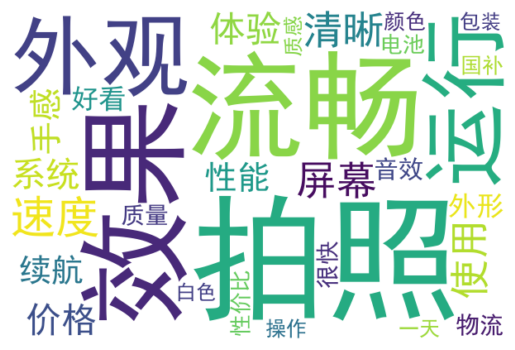

差评主题分析：


,关键词,权重
0,降价,0.027577
1,客服,0.010398
2,国补,0.008891
3,保价,0.008439
4,屏幕,0.007987
5,500,0.007685
6,一个月,0.007535
7,差价,0.007384
8,刚买,0.006480
9,几天,0.005877


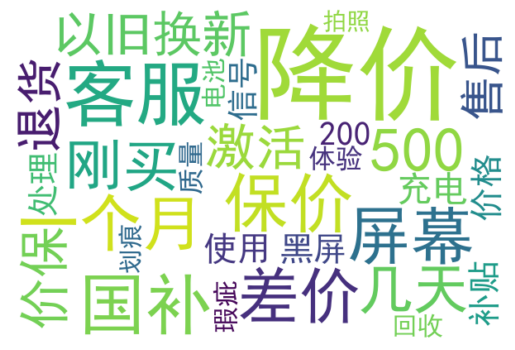

In [18]:
import ast
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('token_data.csv')
df['tokens'] = df['text'].apply(lambda x: x.strip().split())

positive = df[df['标签'] == 1]['tokens'].tolist()
negative = df[df['标签'] == 0]['tokens'].tolist()

# LDA函数
def LDA(token_list, num_topics=1, title=''):
    dictionary = corpora.Dictionary(token_list)
    corpus = [dictionary.doc2bow(text) for text in token_list]
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary,
                                 num_topics=num_topics, random_state=42,
                                 passes=10, alpha='auto')
    
    for i in range(num_topics):
        
        # 生成表格
        topic_words = lda_model.show_topic(i, topn=10)
        df_topic = pd.DataFrame(topic_words, columns=['关键词', '权重'])
        display(df_topic)
        
        # 生成词云
        word_freq = dict(lda_model.show_topic(i, topn=30))
        wc = WordCloud(font_path='simhei.ttf', background_color='white',
                       width=600, height=400).generate_from_frequencies(word_freq)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()

# 提取好评和差评
print("好评主题分析：")
LDA(positive, title='正面评论')

print("差评主题分析：")
LDA(negative, title='负面评论')

从整体效果来看，LDA 模型能够覆盖较全面的评论内容，其提取的主题数量合理、覆盖了用户对产品的不同维度关注。但在具体表现上，仍存在以下不足之处：

- 关键词权重分布分散:LDA 提取的主题中，关键词权重较为平均，核心高权重词不突出，导致主题的主要特征词难以快速概括，降低了解读效率。

- 语义理解能力有限:由于 LDA 仅基于词频共现进行建模，缺乏对词语上下文和深层语义的理解能力，部分主题存在无明显含义的词(如500)。

- 对小规模数据敏感:在本项目约 2000 条评论的数据规模下，LDA 的主题一致性和稳健性受限，个别主题下词分布波动较大，易受数据噪声干扰。

总而言之,LDA 模型作为传统主题建模方法，在初步探索评论主题时具备参考价值，能够快速产出话题大纲。但其在本数据集上的表现也验证了其局限性。

### 2. Top2Vec模型

为了提升主题提取的语义准确性和表达效果，我引入了更先进的深度主题模型 Top2Vec。Top2Vec 利用文档和词语的嵌入向量，通过密度聚类方法自动发现语义空间中的主题，无需预先设定主题数。这种方法能够更好地捕捉文本的上下文信息和深层语义关系，显著优于传统基于词频的模型。相比 LDA，Top2Vec 具有以下优势：

- 自动确定主题数量，避免了手动调整主题数带来的不确定性。

- 深度语义理解能力，基于词向量和文档向量的相似度聚类，主题边界更清晰。

- 适合更大规模的数据，各主题下词波动较小，不易受噪声的干扰。

2025-06-27 20:43:44,474 - top2vec - INFO - Pre-processing documents for training
2025-06-27 20:43:44,601 - top2vec - INFO - Loading universal-sentence-encoder-multilingual model at ./universal-sentence-encoder-multilingual
2025-06-27 20:43:47,868 - top2vec - INFO - Creating joint document/word embedding
2025-06-27 20:43:54,076 - top2vec - INFO - Creating lower dimension embedding of documents
2025-06-27 20:43:56,428 - top2vec - INFO - Finding dense areas of documents
2025-06-27 20:43:56,465 - top2vec - INFO - Finding topics


,关键词,权重
0,效果,0.283900
1,音效,0.256810
2,外观,0.248154
3,性能,0.242231
4,拍照,0.228073
5,待机时间,0.210817
6,屏幕,0.196916
7,流畅,0.196846
8,好看,0.193841
9,外观设计,0.191960


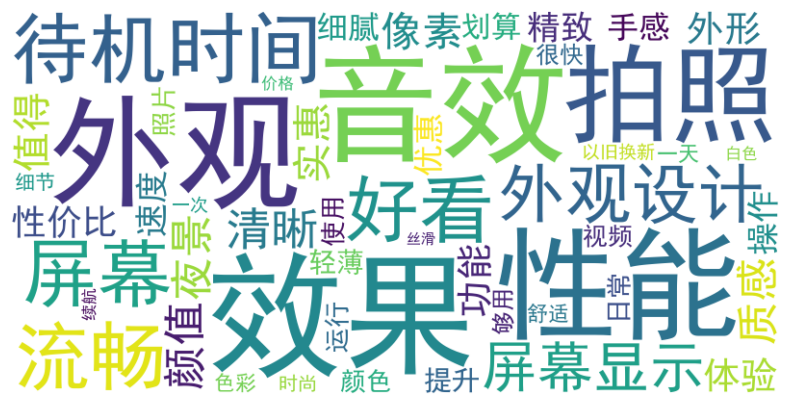

2025-06-27 20:43:57,502 - top2vec - INFO - Pre-processing documents for training
2025-06-27 20:43:57,535 - top2vec - INFO - Loading universal-sentence-encoder-multilingual model at ./universal-sentence-encoder-multilingual
2025-06-27 20:44:01,665 - top2vec - INFO - Creating joint document/word embedding
2025-06-27 20:44:04,500 - top2vec - INFO - Creating lower dimension embedding of documents
2025-06-27 20:44:06,631 - top2vec - INFO - Finding dense areas of documents
2025-06-27 20:44:06,667 - top2vec - INFO - Finding topics


,关键词,权重
0,降价,0.624999
1,保价,0.413933
2,国补,0.169912
3,客服,0.137055
4,屏幕,0.046094


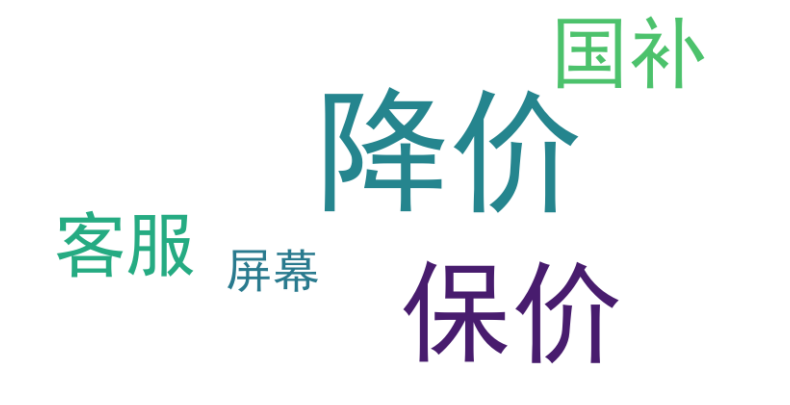

In [20]:
from top2vec import Top2Vec
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# 读取数据
df = pd.read_csv('token_data.csv')
positive_texts = df[df['标签'] == 1]['text'].tolist()
negative_texts = df[df['标签'] == 0]['text'].tolist()

# 定义函数
def TOP(texts,title):

    # 建立模型
    model = Top2Vec(documents=texts, 
                    embedding_model='universal-sentence-encoder-multilingual', 
                    embedding_model_path='./universal-sentence-encoder-multilingual'
                    )

    # 获取Top10关键词
    topic_words, word_scores, topic_nums = model.get_topics() 
    df_topic = pd.DataFrame({'关键词': topic_words[0][:10],'权重': word_scores[0][:10]})
    display(df_topic)

    # 生成词云
    word_freq = dict(zip(topic_words[0], word_scores[0]))
    wc = WordCloud(font_path='simhei.ttf', background_color='white',
                   width=800, height=400).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 分析好评与差评
TOP(positive_texts,'好评')
TOP(negative_texts,'差评')

通过 Top2Vec 模型对用户评论进行主题提取，模型自动生成了各自的主题，分别对应好评和差评两大类别。具体表现如下：

- 主题聚焦：模型自动为好评和差评分别提取了 1 个主题，体现出较强的主题聚类能力，以及针对不同规模数据的适应能力。

- 关键词数量：好评主题包含 10 个关键词，而差评主题则包含 5 个关键词，说明模型根据评论内容自动调整关键词数量，体现出对主题内容的敏感度和差异化理解。

- 关键词权重：各主题的关键词权重差异显著，说明模型能够准确区分核心关键词与辅助关键词，提取结果较为集中且具有代表性。

综合来看，Top2Vec 在本项目中的表现优于传统 LDA 模型，其能自动发现并聚焦核心主题，且提取出的关键词较为全面且聚合性强。该模型的语义表达能力和自动化特性使其非常适合用作本项目的最终主题提取方案。

## 五、产品分析

### 1. 亮点分析

根据Top2Vec模型对提取的好评主题结果，共得到了 10 个高权重关键词。为了更好地理解用户对产品的正面评价焦点，我对这些关键词按语义和功能归类，总结为以下三大核心维度：

- **外观类**：体现用户对产品外观设计、质感、工艺的高度认可。

- **性能类**：突出产品在速度、流畅性、续航等方面的优异表现。

- **多媒体类**：聚焦用户在拍照、音效、屏幕显示等使用体验上的积极反馈。

为了更直观呈现不同亮点类别的权重分布，我制作了以下可视化图表：

- **柱状图**：展示每个关键词类别在主题中的出现频次和权重，让用户关注点一目了然。

- **雷达图**：多维度对比三大类亮点的综合评分和用户关注度，清晰体现各亮点的相对优势。

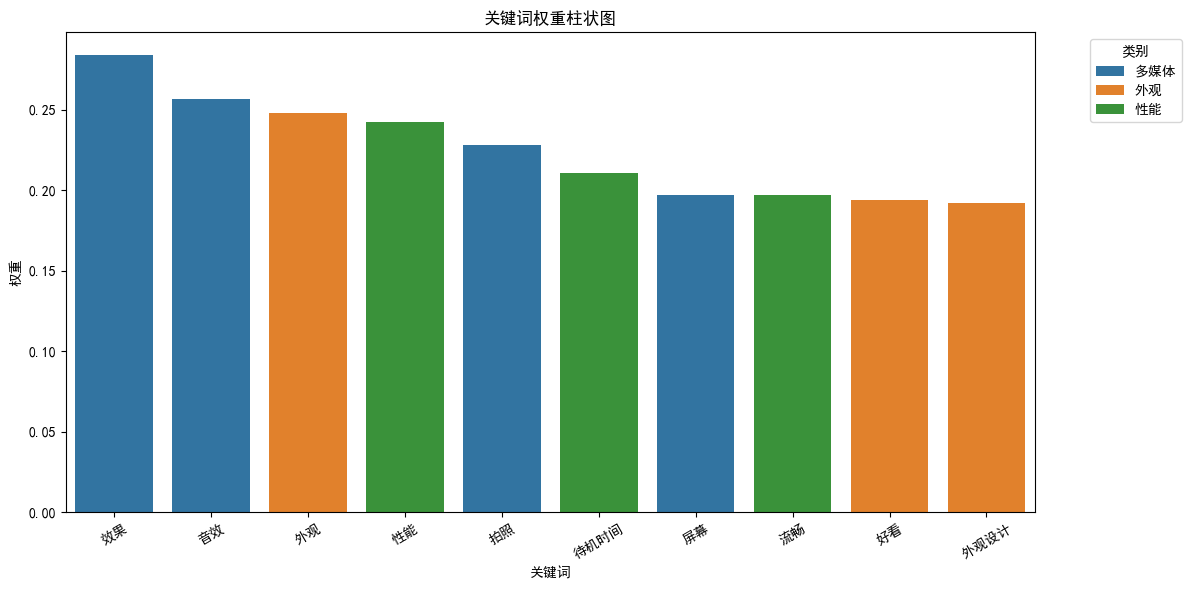

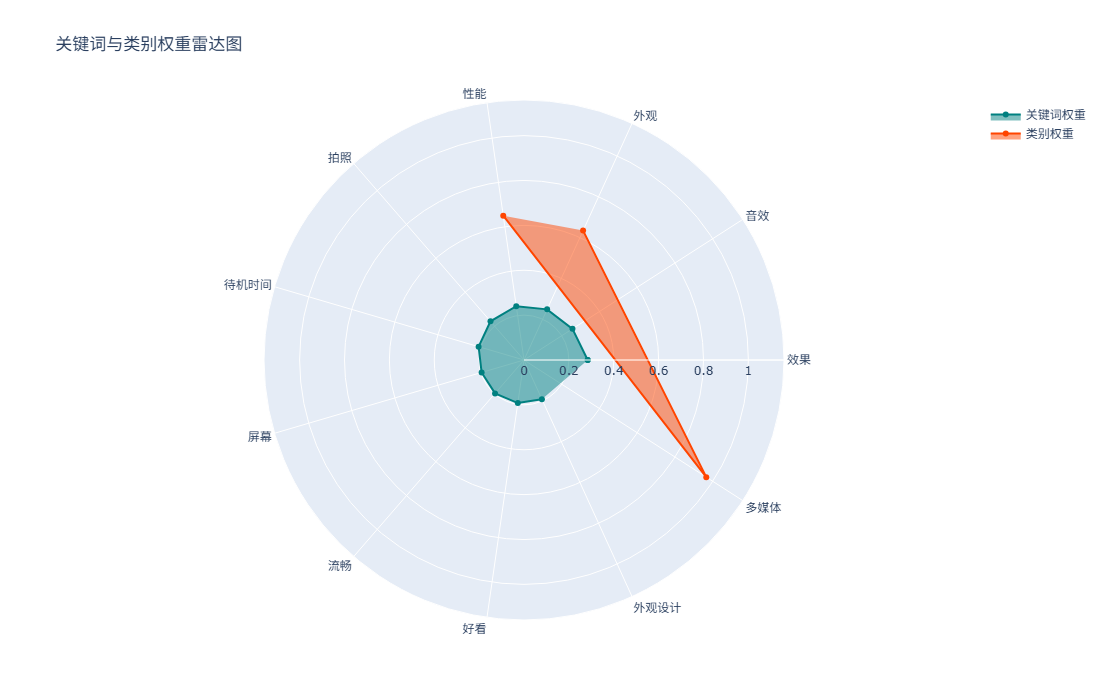

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import rcParams

# 防止乱码
rcParams['font.sans-serif'] = ['SimHei']

# 准备数据
data = {
    "类别": ["多媒体", "多媒体", "外观","性能", "多媒体", "性能", "多媒体", "性能", "外观", "外观"],
    '关键词': ['效果', '音效', '外观', '性能', '拍照', '待机时间', '屏幕', '流畅', '好看', '外观设计'],
    '权重': [0.283900, 0.256810, 0.248154, 0.242231, 0.228073,
             0.210817, 0.196916, 0.196846, 0.193841, 0.191960]
}
df = pd.DataFrame(data)

# 绘制柱状图
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="关键词", y="权重", hue="类别")
plt.title("关键词权重柱状图")
plt.legend(title='类别', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=30)  
plt.tight_layout()
plt.show()

# 关键词数据
labels_kw = df['关键词'].tolist()
stats_kw = df['权重'].tolist()

labels_kw.append(labels_kw[0])
stats_kw.append(stats_kw[0])

# 类别数据
avg_weight = df.groupby("类别")["权重"].sum().reset_index()
labels_cat = avg_weight['类别'].tolist()
stats_cat = avg_weight['权重'].tolist()

labels_cat.append(labels_cat[0])
stats_cat.append(stats_cat[0])

# 合并标签
combined_labels = labels_kw[:-1] + labels_cat[:-1]
combined_values_kw = stats_kw[:-1] + [None]*len(labels_cat[:-1])
combined_values_cat = [None]*len(labels_kw[:-1]) + stats_cat[:-1]

#  绘图
fig = go.Figure()

# 关键词线
fig.add_trace(go.Scatterpolar(
    r=combined_values_kw + [combined_values_kw[0]],
    theta=combined_labels + [combined_labels[0]],
    fill='toself',
    name='关键词权重',
    line_color='teal'
))

# 类别线
fig.add_trace(go.Scatterpolar(
    r=combined_values_cat + [combined_values_cat[0]],
    theta=combined_labels + [combined_labels[0]],
    fill='toself',
    name='类别权重',
    line_color='orangered'
))

# 设置图形
fig.update_layout(
    title="关键词与类别权重雷达图",
    polar=dict(
        radialaxis=dict(visible=True, range=[0, max(stats_kw + stats_cat)*1.2])
    ),
    showlegend=True,
    width=700,
    height=700
)

fig.show()

根据柱状图与雷达图的结果,针对每一类产品亮点进行分析:

- **多媒体**：多媒体体验相关的好评权重几乎覆盖全部，接近 97%，说明ipone16在屏幕显示、音效、拍照质量上有非常突出的表现。特别适合追求影音娱乐、社交分享和内容创作的用户群体。

- **性能**：这部分好评占比超过 65%，用户在日常使用过程中对产品的硬实力表现（速度、流畅、稳定性）和续航能力都表示满意。这说明iphone16不仅在跑分和参数上具备竞争力，在实际体验中也赢得了用户的信赖。长续航与高性能的结合大幅提升了用户的使用舒适度。

- **外观**：外观相关好评占比 63%+，用户高度认可产品的外形设计、美学风格。说明iphone16在材质、工艺、配色、造型方面做得非常出色，能够有效吸引注重颜值的消费群体。

通过产品亮点的分析结果，我们能够清晰洞察 iPhone16 在用户心中的主要优势，为后续产品宣传重点、竞品对比、产品迭代改进提供了数据支持和方向指引。

###　2. 痛点分析

根据Top2Vec提取的差评主题结果，共识别出 5 个高权重差评关键词。为了更系统地挖掘用户负面反馈的重点，我结合关键词的语义含义与功能，将其归纳为以下三类：

- **价格与补贴**：涉及用户对价格波动、降价补偿、保价承诺等方面的投诉或不满。

- **售后服务**：体现用户在售后响应、退换货、维修体验上的负面反馈。

- **产品质量**：反映用户对部分产品质量、工艺一致性或瑕疵问题的吐槽。

为更直观展示各类痛点问题的重点和强弱分布，我分别绘制每个差评关键词与类别权重的雷达图，用以揭示不同维度下的主要痛点强度，便于聚焦改进方向。

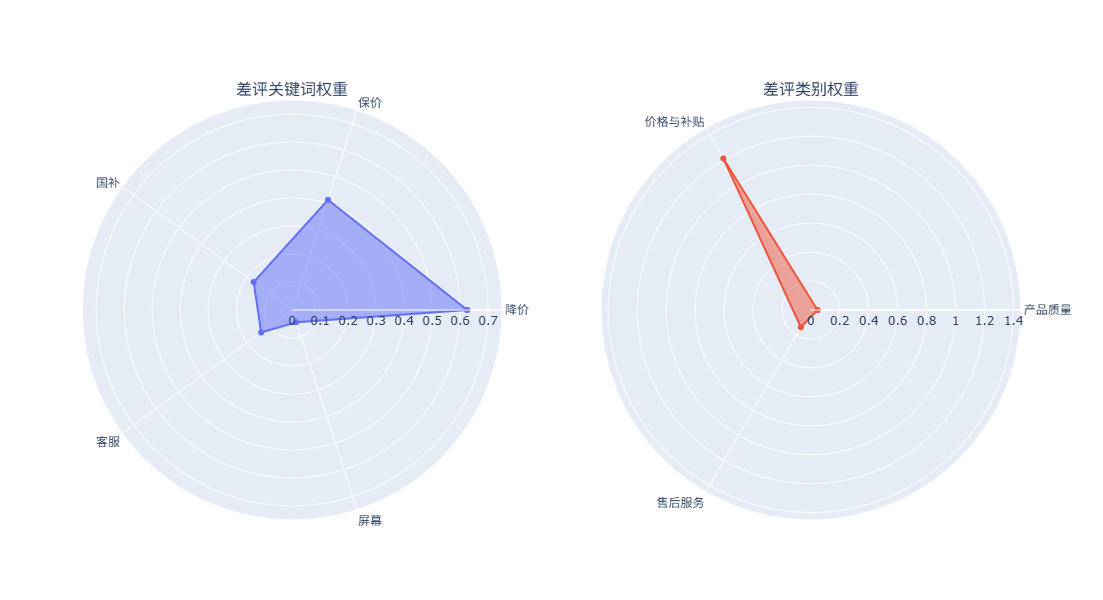

In [29]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

data = {
    '类别' : ['价格与补贴', '价格与补贴','价格与补贴', '售后服务', '产品质量'],
    '关键词': ['降价', "保价", "国补", "客服", "屏幕"],
    '权重': [0.624999, 0.413933,0.169912,0.137055,0.046094]
}
df = pd.DataFrame(data)
df_grouped = df.groupby("类别").sum().reset_index()

# 准备数据
labels_kw = df["关键词"].tolist() + [df["关键词"].tolist()[0]]
stats_kw = df["权重"].tolist() + [df["权重"].tolist()[0]]

labels_cat = df_grouped["类别"].tolist() + [df_grouped["类别"].tolist()[0]]
stats_cat = df_grouped["权重"].tolist() + [df_grouped["权重"].tolist()[0]]

# 绘制合图
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=("差评关键词权重", "差评类别权重")
)

# 关键词雷达
fig.add_trace(go.Scatterpolar(
    r=stats_kw,
    theta=labels_kw,
    fill='toself',
    name='关键词'
), row=1, col=1)

# 类别雷达
fig.add_trace(go.Scatterpolar(
    r=stats_cat,
    theta=labels_cat,
    fill='toself',
    name='类别'
), row=1, col=2)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, max(stats_kw)*1.2])),
    polar2=dict(radialaxis=dict(visible=True, range=[0, max(stats_cat)*1.2])),
    showlegend=False,
    width=1000,
    height=600
)

fig.show()

根据差评关键词与类别雷达图的结果，针对每一类差评进行痛点分析并提出相应优化建议:
- **价格与补贴**

**痛点分析：**

(1)用户对近期价格波动不满（大促后降价、未能及时保价、国补政策执行不到位等）。

(2)有用户因错过补贴或保价导致经济损失，产生负面情绪。

(3)部分用户对价格透明度、补偿机制缺乏信任。

**优化建议：**

(1)加强产品促销宣传并制定价格变动计划，提升价格透明度。

(2)优化保价流程，缩短审核周期，提升补偿效率。

(3)引入“购后无忧险”，减少因短期价格波动造成的不满。
- **售后服务**

**痛点分析：**

(1)客户服务响应慢、解决方案不令用户满意。

(2)售后态度或处理效率未达到用户预期。

**优化建议：**

(1)强化客服培训，特别是补贴、保价等热点问题处理能力。

(2)建立客服质量监控机制，实时收集反馈优化服务。
- **产品质量**

**痛点分析：**

(1)屏幕表现未达部分用户预期，可能涉及色彩、亮度、可视角度、耐用性等方面。

(2)存在个别品控问题（如死点、划痕、漏光等）。

**优化建议：**

(1)加强出厂品控，提升屏幕一致性。

(2)增设屏幕质检承诺，缩短屏幕问题退换周期。

通过聚焦每类产品痛点,提供针对性的优化建议,为产品和服务优化提供了数据支持和方向指引，不仅帮助定位当前 iPhone16 用户关注的关键维度，也为后续运营和产品升级提供了可行的改进思路。未来可结合更多用户反馈和长期趋势分析，持续优化用户体验。